# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%ls checkpoints

No_Dropout_Run/  Test/  TestRun/


In [1]:
checkpoint_path = "Neural-HMM.ckpt"
%load_ext autoreload
%autoreload 3

## Import libraries and setup matplotlib

In [2]:
import matplotlib.pylab as plt

# Download tokenizer if not present
import nltk
nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
%matplotlib inline



[nltk_data] Downloading package punkt to /home/shivam/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Plotting code

In [4]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states_travelled)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [8]:
hparams = create_hparams()

## Load model from checkpoint

In [9]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,292,145 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [11]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [17]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'generator_v1_T2'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [18]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

generator_v1_T2
Loading 'generator_v1_T2'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [19]:
model.model.hmm.hparams.max_sampling_time = 1800
model.model.hmm.hparams.duration_quantile_threshold=0.42
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=True
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set texts

In [20]:
texts = [
    "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent."
]

In [21]:
sequences = []

for i, text in enumerate(texts):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device).long()
    sequences.append(sequence)
    
    print(''.join(['='] * 100))


********************
1 - Input text: 
********************
The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.

********************
1 - Phonetised text: 
********************
{DH AH0} {S IY1 K R AH0 T} {S ER1 V AH0 S} {B IH0 L IY1 V D} {DH AE1 T} {IH1 T} {W AA1 Z} {V EH1 R IY0} {D AW1 T F AH0 L} {DH AE1 T} {EH1 N IY0} {P R EH1 Z IH0 D AH0 N T} {W UH1 D} {R AY1 D} {R EH1 G Y AH0 L ER0 L IY0} {IH0 N} {AH0} {V IY1 HH IH0 K AH0 L} {W IH1 DH} {AH0} {F IH1 K S T} {T AA1 P} , {IY1 V IH0 N} {DH OW1} {T R AE0 N S P EH1 R AH0 N T} .


## Decode text input and plot results

In [22]:
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in sequences:
        mel_output, hidden_state_travelled = model.inference(sequence)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)
        

### Visualisations of the output

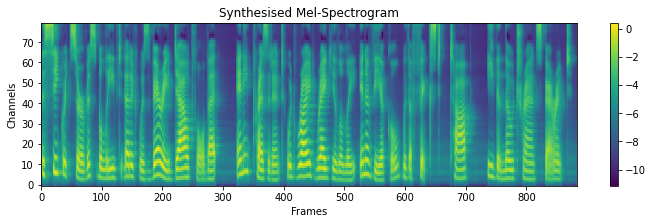

In [23]:
for mel_output in mel_outputs:
    plot_spectrogram_to_numpy(np.array(mel_output).T)

### Synthesize audio from spectrogram using WaveGlow

In [24]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = torch.tensor(mel_output).T.unsqueeze(0).cuda().float()
        audio = generator(mel_output)
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.


***********************************



### Save to wav files using soundfile

In [25]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
    filename = basepath / f'syn_{i + 1}.wav'
    sr = 22500
    sf.write(filename, audio.data.squeeze().cpu().numpy(), 
             22500, 'PCM_24')
    print(f'Successfully written: {filename}')


Successfully written: synthesised_wavs/syn_1.wav
